In [1]:
import numpy as np
import matplotlib.pyplot as plt

%load_ext autoreload
%aimport src.enthalpy_flowband
%autoreload 1
from src.enthalpy_flowband import EnthalpyFlowbandState, EnthalpyFlowbandExplicit

In [3]:
def MH_surface(xs):
    a = -1 / 140625
    b = 7 / 75
    c = 300
    
    return a * xs**2 + b * xs + c

def MH_velocity(xs, zs, surface):
    a = -7 / 2812500
    b = 14 / 375
    c = 10
    decay = 0.6
    shear_ratio = 1 - decay
    fn_x = a * xs**2 + b * xs + c
    fn_z = (1 - decay) * (zs / surface) + decay
    
    return fn_x * fn_z * 3.14e-8

def MH_temperature(t):
    a = 16
    f = 1 / 3.14e7
    b = 20
    
    return a * np.sin(2 * np.pi * f * t) + b

In [4]:
sec_per_a = 3.14e7
total_a = 100
t_final = sec_per_a * total_a
dt = 1e6

In [5]:
state = EnthalpyFlowbandState(500, 500, 30, 1.5, t_final, dt)

In [6]:
state.set_initial_surface(MH_surface)
state.set_pressure_melting_point()
state.set_initial_velocity(MH_velocity)
state.set_air_temperature(MH_temperature)
state.calc_internal_energy()
state.set_initial_conditions(initial_temperature = 268)

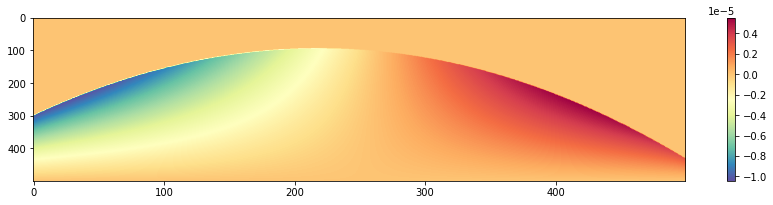

In [9]:
to_plot = state.in_glacier * state.velocity_z

fig, ax = plt.subplots(figsize = (15, 3))
im = ax.imshow(np.flip(to_plot.reshape(state.grid.shape), 0), cmap = 'Spectral_r', aspect = 0.25)
plt.colorbar(im)
plt.show()

In [10]:
enthalpy_x = state.grid.map_mean_of_horizontal_active_links_to_node(state.grid.calc_diff_at_link(state.enthalpy))
enthalpy_z = state.grid.map_mean_of_vertical_active_links_to_node(state.grid.calc_diff_at_link(state.enthalpy))
advection_x = state.velocity_x * enthalpy_x
advection_z = state.velocity_z * enthalpy_z

In [11]:
temperature_dz = state.grid.map_mean_of_vertical_active_links_to_node(state.grid.calc_diff_at_link(state.temperature))
temperature_zz = state.conductivity * state.grid.map_mean_of_vertical_active_links_to_node(state.grid.calc_diff_at_link(temperature_dz))

In [12]:
drainage_coeff = state.rho_water * state.latent_heat
water_flux_coeff = (state.drainage_coeff * state.porosity**state.drainage_exponent) / state.water_viscosity
effective_pressure_z = state.grid.map_mean_of_vertical_active_links_to_node(state.grid.calc_diff_at_link(state.effective_pressure))
water_flux = water_flux_coeff * ((state.rho_water - state.rho_ice) * state.gravity + effective_pressure_z)

In [13]:
def update_effective_pressure():
    coeff = (state.effective_viscosity * state.drainage_coeff) / state.water_viscosity
    inner = state.porosity**state.drainage_exponent * ((state.rho_water - state.rho_ice) * state.gravity + effective_pressure_z)
    div_inner = state.grid.map_mean_of_vertical_active_links_to_node(state.grid.calc_diff_at_link(inner))
    solution = coeff * div_inner
    return solution

In [14]:
solution = update_effective_pressure()
effective_pressure = np.where(state.is_temperate == 1, solution / state.porosity, state.hydrostatic_pressure)

/tmp/ipykernel_10291/3026278424.py:2: RuntimeWarning: invalid value encountered in true_divide
  effective_pressure = np.where(state.is_temperate == 1, solution / state.porosity, state.hydrostatic_pressure)


In [15]:
def run_one_step(max_inner_iter = 100, inner_tol = 1e-3):
    enthalpy_x = state.grid.map_mean_of_horizontal_active_links_to_node(state.grid.calc_diff_at_link(state.enthalpy))
    enthalpy_z = state.grid.map_mean_of_vertical_active_links_to_node(state.grid.calc_diff_at_link(state.enthalpy))
    advection_x = state.velocity_x * enthalpy_x
    advection_z = state.velocity_z * enthalpy_z
    
    temperature_dz = state.grid.map_mean_of_vertical_active_links_to_node(state.grid.calc_diff_at_link(state.temperature))
    diffusion = state.conductivity * state.grid.map_mean_of_vertical_active_links_to_node(state.grid.calc_diff_at_link(temperature_dz))
    
    drainage_coeff = state.rho_water * state.latent_heat
    water_flux_coeff = (state.drainage_coeff * state.porosity**state.drainage_exponent) / state.water_viscosity
    effective_pressure_z = state.grid.map_mean_of_vertical_active_links_to_node(state.grid.calc_diff_at_link(state.effective_pressure))
    water_flux = drainage_coeff * water_flux_coeff * ((state.rho_water - state.rho_ice) * state.gravity + effective_pressure_z)
    
    for i in range(max_inner_iter):
        pressure_solution = update_effective_pressure()
        new_effective_pressure = np.where(state.is_temperate == 1, pressure_solution / state.porosity, state.hydrostatic_pressure)
        difference = state.effective_pressure - new_effective_pressure
        state.effective_pressure = new_effective_pressure
        
        if np.max(np.abs(difference)) <= inner_tol:
            break
    
    dhdt = advection_x + advection_z + diffusion + water_flux - state.internal_energy
    new_enthalpy = dhdt * state.dt
    
    return new_enthalpy

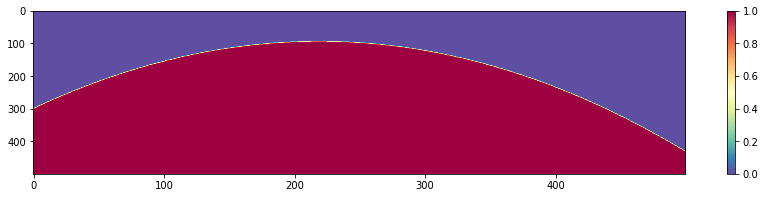

In [18]:
to_plot = state.in_glacier

fig, ax = plt.subplots(figsize = (15, 3))
im = ax.imshow(np.flip(to_plot.reshape(state.grid.shape), 0), cmap = 'Spectral_r', aspect = 0.25)
plt.colorbar(im)
plt.show()

In [25]:
surface = MH_surface(state.grid.node_x[0:state.nx])
surface_nodes = state.grid.find_nearest_node((state.grid.node_x[0:state.nx], surface), mode = 'clip')
in_surface = np.array([1 if idx in surface_nodes else 0 for idx in np.ravel(state.grid.nodes)])

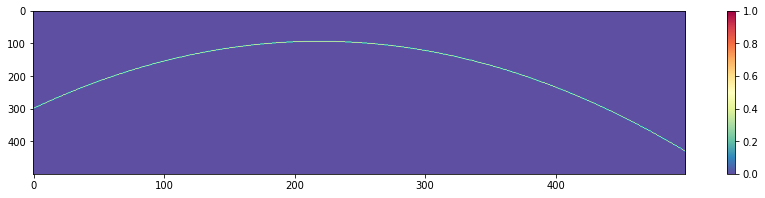

In [26]:
to_plot = in_surface

fig, ax = plt.subplots(figsize = (15, 3))
im = ax.imshow(np.flip(to_plot.reshape(state.grid.shape), 0), cmap = 'Spectral_r', aspect = 0.25)
plt.colorbar(im)
plt.show()